In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
HOUSING_PATH = os.path.join("E:", "HVintroductionToAIAndMachinLearning", "housingDataSet")

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

C:\Users\OMID\AppData\Local\Temp\ipykernel_3896\684986203.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
corr_matrix = housing.drop("ocean_proximity", axis=1).corr()

In [7]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [8]:
import numpy as np

housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

split_obj = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split_obj.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [10]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [11]:
housing_features = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [12]:
housing_features_num = housing_features.drop("ocean_proximity", axis=1)

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attr_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler())
])

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing_features_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing_features)

In [16]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [17]:
housing_prepared.shape

(16512, 16)

In [56]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [70]:
from sklearn.metrics import root_mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)

In [72]:
lin_rmse

68627.87390018745

In [74]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [76]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)

In [78]:
tree_rmse

0.0

In [97]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [99]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = root_mean_squared_error(housing_labels, housing_predictions)

In [101]:
forest_rmse

18650.698705770003

In [103]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [84]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [86]:
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180657


In [88]:
display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [105]:
display_scores(forest_rmse_scores)

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


In [107]:
housing_prepared_subset = housing_prepared[:5000]
housing_labels_subset = housing_labels[:5000]

In [151]:
from sklearn.svm import SVR

def svm_handler(kernel, c_vals, prepared_data, labels, gamma_vals=None):
    if kernel == "rbf" and gamma_vals:
        for c in c_vals:
            for gamma in gamma_vals:
                svm_reg = SVR(kernel=kernel, C=c, gamma=gamma)
                svm_reg.fit(prepared_data, labels)
                housing_predictions = svm_reg.predict(prepared_data)
                svm_rmse = root_mean_squared_error(labels, housing_predictions)
                svm_scores = cross_val_score(svm_reg, prepared_data, labels, scoring="neg_mean_squared_error", cv=3)
                svm_rmse_scores = np.sqrt(-svm_scores)

                print(f"With rbf kernel and for C={c} and gamma={gamma}:")
                print(f"Root Mean Squared Error = {svm_rmse}")
                display_scores(svm_rmse_scores)
    else:
        for c in c_vals:
            svm_reg = SVR(kernel=kernel, C=c)
            svm_reg.fit(prepared_data, labels)
            housing_predictions = svm_reg.predict(prepared_data)
            svm_rmse = root_mean_squared_error(labels, housing_predictions)
            svm_scores = cross_val_score(svm_reg, prepared_data, labels, scoring="neg_mean_squared_error", cv=3)
            svm_rmse_scores = np.sqrt(-svm_scores)

            print(f"With linear kernel and for C={c}:")
            print(f"Root Mean Squared Error = {svm_rmse}")
            display_scores(svm_rmse_scores)


In [155]:
c_values = [0.01, 0.1, 1, 10, 100, 1000]
svm_handler(kernel="linear", c_vals=c_values, prepared_data=housing_prepared, labels=housing_labels)

With linear kernel and for C=0.01:
Root Mean Squared Error = 118846.39027904598
Scores: [117533.45599075 119192.20869005 119869.41386748]
Mean: 118865.02618276025
Standard deviation: 981.3124189153197
With linear kernel and for C=0.1:
Root Mean Squared Error = 118094.76393750205
Scores: [116983.67547217 118702.09888194 119368.75913345]
Mean: 118351.51116251822
Standard deviation: 1004.7685735494603
With linear kernel and for C=1:
Root Mean Squared Error = 111095.06635291966
Scores: [112168.27185368 113927.12377593 114551.21465604]
Mean: 113548.87009521702
Standard deviation: 1008.9304518691699
With linear kernel and for C=10:
Root Mean Squared Error = 81932.39323149915
Scores: [85742.92204359 87833.06301019 87671.36051073]
Mean: 87082.448521505
Standard deviation: 949.4859357764433
With linear kernel and for C=100:
Root Mean Squared Error = 71258.59821420886
Scores: [70490.0256935  73566.89643639 72313.27477373]
Mean: 72123.39896787515
Standard deviation: 1263.2822351162708
With linear

In [157]:
c_values = [0.01, 0.1, 1, 10, 100, 1000]
gamma_values = [0.001, 0.01, 0.1, 1, 10, 100]
svm_handler(kernel="rbf", c_vals=c_values, prepared_data=housing_prepared, labels=housing_labels, gamma_vals=gamma_values)

With rbf kernel and for C=0.01 and gamma=0.001:
Root Mean Squared Error = 118922.18759540698
Scores: [117585.47442437 119267.72595033 119926.6679135 ]
Mean: 118926.62276273184
Standard deviation: 985.7519217437215
With rbf kernel and for C=0.01 and gamma=0.01:
Root Mean Squared Error = 118921.15440105139
Scores: [117584.88044127 119266.62169577 119925.76462456]
Mean: 118925.75558719768
Standard deviation: 985.5884766204535
With rbf kernel and for C=0.01 and gamma=0.1:
Root Mean Squared Error = 118919.03567366683
Scores: [117584.07830838 119264.72124227 119924.4194648 ]
Mean: 118924.40633848352
Standard deviation: 985.2782542402166
With rbf kernel and for C=0.01 and gamma=1:
Root Mean Squared Error = 118921.86507108576
Scores: [117585.42069215 119267.45971554 119926.59364065]
Mean: 118926.49134944659
Standard deviation: 985.7204687256512
With rbf kernel and for C=0.01 and gamma=10:
Root Mean Squared Error = 118922.34452396714
Scores: [117585.57109109 119267.85667421 119926.78497836]
Mea

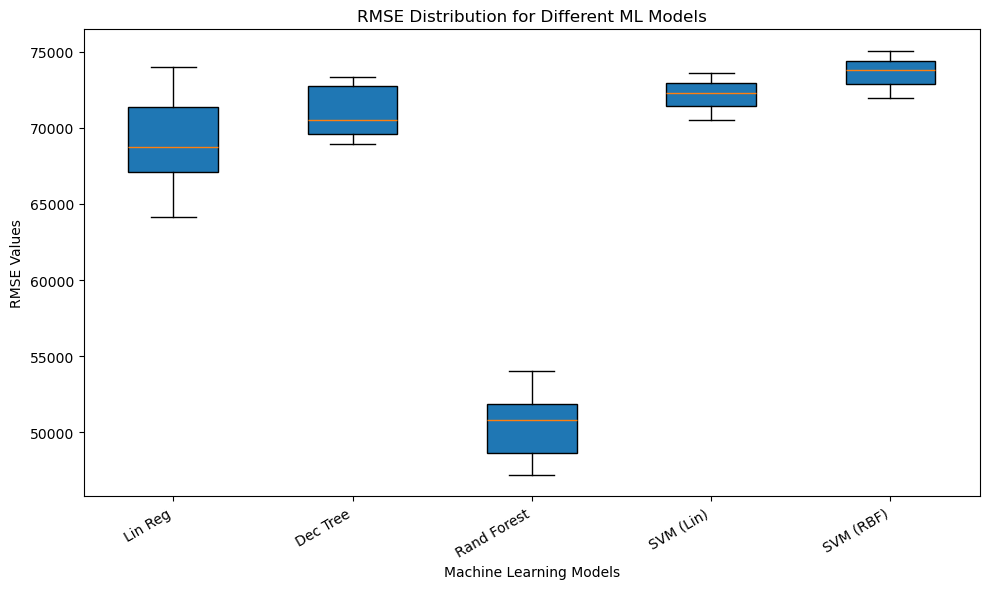

In [15]:
import matplotlib.pyplot as plt

rmse_scores = [
    [71762.76364394, 64114.99166359, 67771.17124356, 68635.19072082, 66846.14089488, 72528.03725385, 73997.08050233, 68802.33629334, 66443.28836884, 70139.79923956],  # Lin Reg (10 folds)
    [72831.45749112, 69973.18438322, 69528.56551415, 72517.78229792, 69145.50006909, 79094.74123727, 68960.045444, 73344.50225684, 69826.02473916, 71077.09753998],  # Dec Tree (10 folds)
    [51559.63379638, 48737.57100062, 47210.51269766, 51875.21247297, 47577.50470123, 51863.27467888, 52746.34645573, 50065.1762751, 48664.66818196, 54055.90894609],  # Rand Forest (10 folds)
    [70490.0256935, 73566.89643639, 72313.27477373],  # SVM (Lin) (3 folds)
    [71969.8314058, 75067.29587675, 73759.18594993]   # SVM (RBF) (3 folds)
]

ML_models = ['Lin Reg', 'Dec Tree', 'Rand Forest', 'SVM (Lin)', 'SVM (RBF)']

plt.figure(figsize=(10,6))
plt.boxplot(rmse_scores, labels=ML_models, patch_artist=True, showfliers=False)

plt.xlabel('Machine Learning Models')
plt.ylabel('RMSE Values')
plt.title('RMSE Distribution for Different ML Models')

plt.xticks(rotation=30, ha='right')
plt.tight_layout()

plt.savefig('rmse_box_plot.png')

plt.show()
